In [1]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import YahooDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit import Aer, execute
from qiskit.algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit.opflow import PauliExpectation, CVaRExpectation
import datetime, matplotlib.pyplot as plt, numpy as np

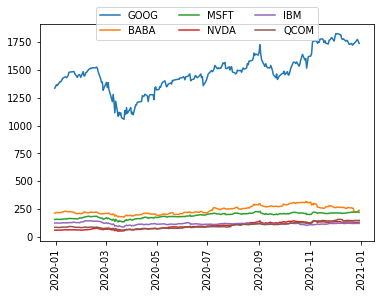

In [2]:
stocks = ["GOOG", "BABA", "MSFT", "NVDA", "IBM", "QCOM"]
try:
    data = YahooDataProvider(
                 tickers = stocks,
                 start=datetime.datetime(2020, 1, 1),
                 end=datetime.datetime(2020, 12, 31))
    
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex: 
    data = None
    print(ex)

In [3]:
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


In [4]:
q = 0.5                   # set risk factor
budget = 1  # set budget
penalty = len(stocks)      # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()


In [5]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
    
#     eigenstate = result.min_eigen_solver_result.eigenstate
#     eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
#     probabilities = np.abs(eigenvector)**2
#     i_sorted = reversed(np.argsort(probabilities))
#     print('\n----------------- Full result ---------------------')
#     print('selection\tvalue\t\tprobability')
#     print('---------------------------------------------------')
#     for i in i_sorted:
#         x = index_to_selection(i, len(stocks))
#         value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
#         #value = portfolio.to_quadratic_program().objective.evaluate(x)
#         probability = probabilities[i]
#         print('%10s\t%.4f\t\t%.4f' %(x, value, probability))
        

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 1. 0. 0.], value -0.0032


In [6]:
from qiskit.opflow import PauliExpectation, CVaRExpectation


seed = 123
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
cvar_exp = CVaRExpectation(0.1, PauliExpectation())
qaoa_mes = QAOA(expectation=cvar_exp, optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 1. 0. 0.], value -0.0032
